<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea17_electrical_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from scipy import stats

In [3]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = serie.ravel() ## Con esto quitamos el bracket o corchete en cada uno de loselementos del arreglo

## Una red de juguete con Networkx

In [4]:
## https://github.com/urieliram/statistical/blob/main/Tarea13.ipynb
#serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,9
#,9,0,7,5,5,6,0,4,3,5,5,3,5,0,2,0,5,0,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,3,2
#,3,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,2,1,7
#,3,3,2,5,3,5,7,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,4,0,3,4,5,4,0,5
#,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,2,3,9,5,7,5,3,5,9,5,4,0,2,4,4,6,1,0,5,0
#,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,4,9,0,2,5,6
#,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,2,5,2,7,2,5,0,4,5,6,9,0,5,4,0]

serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,
         9,9,0,7,5,5,6,0,4,3,5,5,5,5,0,2,0,5,5,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,
         3,2,0,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,
         2,1,7,3,5,2,5,3,5,6,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,3,0,3,4,
         5,3,0,5,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,5,3,9,5,7,5,3,5,9,5,4,0,2,4,4,
         6,1,0,5,0,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,
         4,9,0,2,5,6,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,5,5,5,7,2,5,0,4,5,6,0,0,5,4,0]


In [5]:
nodes = np.unique(serie)
n = len(nodes)
A = np.zeros(shape=(n,n))

In [6]:
for i in range(len(serie)-1):
    A[serie[i],serie[i+1]] = A[serie[i],serie[i+1]] + 1
A

array([[10.,  1.,  9.,  6.,  5., 12.,  3.,  4.,  0.,  0.],
       [ 2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  0.],
       [ 6.,  2.,  2.,  0.,  4.,  6.,  4.,  2.,  1.,  1.],
       [ 5.,  0.,  2.,  0.,  2.,  8.,  1.,  0.,  0.,  1.],
       [ 3.,  0.,  0.,  5.,  2.,  4.,  2.,  1.,  0.,  4.],
       [13.,  1.,  7.,  5.,  3., 16.,  6.,  4.,  1.,  4.],
       [ 5.,  4.,  2.,  0.,  3.,  6.,  3.,  0.,  0.,  1.],
       [ 2.,  0.,  2.,  2.,  0.,  3.,  3.,  1.,  0.,  4.],
       [ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 3.,  0.,  3.,  0.,  1.,  4.,  1.,  2.,  1.,  1.]])

In [7]:
#G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(nodes)

In [10]:
rows = A.shape[0]
cols = A.shape[1]
for i in range(0, cols - 1):
    for j in range(0, rows -1):
        if A[i,j] != 0:
            G.add_edge(i, j)
            G.edges[i, j]['color'] = "red"


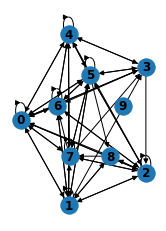

In [11]:
subax1 = plt.subplot(121)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

[Creating a graph Networkx](https://networkx.org/documentation/stable/tutorial.html)

[Drawing graphs Networkx](https://networkx.org/documentation/stable/tutorial.html#drawing-graphs)

[A study of visibility graphs for time series representations](https://upcommons.upc.edu/bitstream/handle/2117/328691/152711.pdf?sequence=1&isAllowed=y)

In [ ]:
 pip install pandapower

In [ ]:
pip install python-igraph

In [ ]:
pip install igraph

In [ ]:
pip install haversine

In [ ]:
pip install pyproj

## Una red con Pandapower
Nodos
0.   Número de bus.
1.   Nombre completo del bus.
2.   Nombre abreviado del bus.
3.   Número del área.
4.   Nombre del área completo.
5.   Nombre del área abreviado.
6.   Tensión nominal (KV). (F
7.   Subsistema eléctrico.
8.   Nombre completo de región de precios.
9.   Nombre abreviado de región de precios.
10.  Número de la región de precios.
11.  Disponibilidad inicial del nodo.

Ramas
0.   Número de la rama.
1.   Nombre completo de la rama.
2.   Índice del nodo origen.
3.   Nombre del nodo origen.
4.   Índice del nodo destino.
5.   Nombre del nodo destino.
6.   Resistencia de la rama en pu.
7.   Reactancia de la rama en pu.
8.   Disponibilidad inicial de la rama.
9.   Tipos de rama (1: línea, 2: transformador).

Cargas
0.   Nombre de la carga.
1.   -
2.   -
3.   Número de nodo asociado.
4.   Bandera de nodo distribuido (1-Sí/0-No)
5.   Índice de archivo de los factores de distribución de carga (0-Ninguno/1,2,3…)

Carga fija
0.   Carga fija (MW) del periodo 1.
1.   Carga fija (MW) del periodo 168


In [104]:
path            = 'https://drive.google.com/uc?export=download&id=' 
URL_Nodos       = 'https://drive.google.com/file/d/1-IYKCtbbvDJNWTtb7Dyp4-rpn4AyGHcC/view?usp=sharing'
URL_Ramas       = 'https://drive.google.com/file/d/18gSw-z-8WeXSRdnIde_iSe0mJLFmaFWB/view?usp=sharing'
URL_Cargas      = 'https://drive.google.com/file/d/1--H0OVEU9mVZSkpB9U_JlbHgPLflWbY7/view?usp=sharing'
URL_Carfija     = 'https://drive.google.com/file/d/1tMUgnaIiC1vAx71YUcQPImc-ZsVtnUXw/view?usp=sharing'
df_Nodos  = pd.read_csv(path+URL_Nodos.split('/')[-2],usecols=[0,1,2,3,4,5,6,7,8,9,10,11],names=['No','Name','Avr','Region','Place','Place2','KV','Sub','Prices','Prices2','Price3','Avail'])
df_Nodos.dropna(inplace=True)
nodos = df_Nodos.to_numpy()
df_Ramas  = pd.read_csv(path+URL_Ramas.split('/')[-2],usecols=[0,1,2,3,4,5,6,7,8,9],names=['No','Name','Orig','NameOrig','Destino','NameDest','R','X','Type','Avail'])
df_Ramas.dropna(inplace=True)
ramas = df_Ramas.to_numpy()
df_Cargas  = pd.read_csv(path+URL_Cargas.split('/')[-2],usecols=[0,1,2,3,4,5],names=['Name','x','xx','Node','Ban','Dist'])
df_Cargas.dropna(inplace=True)
cargas = df_Cargas.to_numpy()
df_Carfija  = pd.read_csv(path+URL_Carfija.split('/')[-2],usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],names=['H0','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23'])
df_Carfija.dropna(inplace=True)
carfijas = df_Carfija.to_numpy()

In [ ]:
df_Nodos['Prices'].unique()

In [177]:
import pandapower as pp
import igraph
from pandapower.plotting.plotly.mapbox_plot import set_mapbox_token
set_mapbox_token('pk.eyJ1IjoidXJpZWxpcmFtIiwiYSI6ImNsM2dueG4xbjA3bWgza3F4eGgycmRqdjkifQ.sMA3nPp-O4R7f5PJmViFog')

In [178]:
## http://www.pandapower.org/start/
net = pp.create_empty_network(name='WEM', f_hz=60.0) ## Crea una red vacia
node = []
for i in nodos:
    node.append(pp.create_bus(net,vn_kv=i[6], name=i[1],geodata=(28.426846,77.088834),zone=i[5],in_service=True)) ## https://pandapower.readthedocs.io/en/v2.9.0/elements/bus.html

In [179]:
j=0
for i in cargas:
    #print(cargas[j][3],carfijas[j][0],cargas[j][0])
    pp.create_load(net, bus=node[cargas[j][3]-1], p_mw=carfijas[j][0], q_mvar=0, name=cargas[j][0])
    j=j+1

In [181]:
from haversine import Unit
import haversine as hs
for i in ramas:
    loc1=(28.426846,77.088834)
    loc2=(28.394231,77.050308)
    km = hs.haversine(loc1,loc2,unit=Unit.METERS)
    pp.create_line(net, from_bus=node[i[2]-1], to_bus=node[i[4]-1],std_type="NAYY 4x50 SE", name=i[1],in_service=i[9],length_km=km) # ## https://pandapower.readthedocs.io/en/v2.2.1/elements/line.html

In [ ]:
pp.runpp(net) ## Flujos de potencia https://pandapower.readthedocs.io/en/v2.0.0/powerflow.html

In [188]:
from pandapower.networks import mv_oberrhein
net = mv_oberrhein()

In [190]:
from pandapower.plotting.plotly import simple_plotly, vlevel_plotly
from pandapower.networks import mv_oberrhein
import pyproj
## https://pandapower.readthedocs.io/en/v2.9.0/plotting/plotly/built-in_plots.html
#pp.plotting.create_generic_coordinates(net, mg=None, library='igraph', respect_switches=False)
simple_plotly(net, on_map=True, projection='epsg:31467')

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

Existing geodata are not real lat/lon geographical coordinates. -> plot on maps is not possible.
Use geo_data_to_latlong(net, projection) to transform geodata from specific projection.


In [191]:
vlevel_plotly(net)

In [192]:
pf_res_plotly(net)

NameError: ignored